## Imports

In [ ]:
import torch
import torchaudio
import torchaudio.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import librosa
import soundfile as sf
import shutil
from sklearn.cluster import KMeans
from tqdm import tqdm
import seaborn as sns
from sklearn import cluster
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans


data_root = "/home/george-vengrovski/Documents/TweetyBERT/llb3_data_matrices"

torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

## Preprocessing

In [ ]:
import psuedo_label_generation

data_root = "/home/george-vengrovski/Documents/canary_song_detector/data"
train = "/home/george-vengrovski/Documents/canary_song_detector/train"
test = "/home/george-vengrovski/Documents/canary_song_detector/test"

processor = psuedo_label_generation.SpectrogramProcessor(data_root=data_root, train_dir=train, test_dir=test, n_clusters=100)

### CAREFUL
processor.clear_directory(train)
processor.clear_directory(test)
### CAREFUL 

processor.generate_train_test()
# this is 5,000 samples * num times in samples (10 in the case of 100 timebins in 1000 timebin segment)
processor.generate_embedding(samples=5e3, time_bins_per_sample=100, reduction_dims=2)
processor.plot_embedding_and_labels()
processor.generate_train_test_labels(reduce=False)

## Data Loader

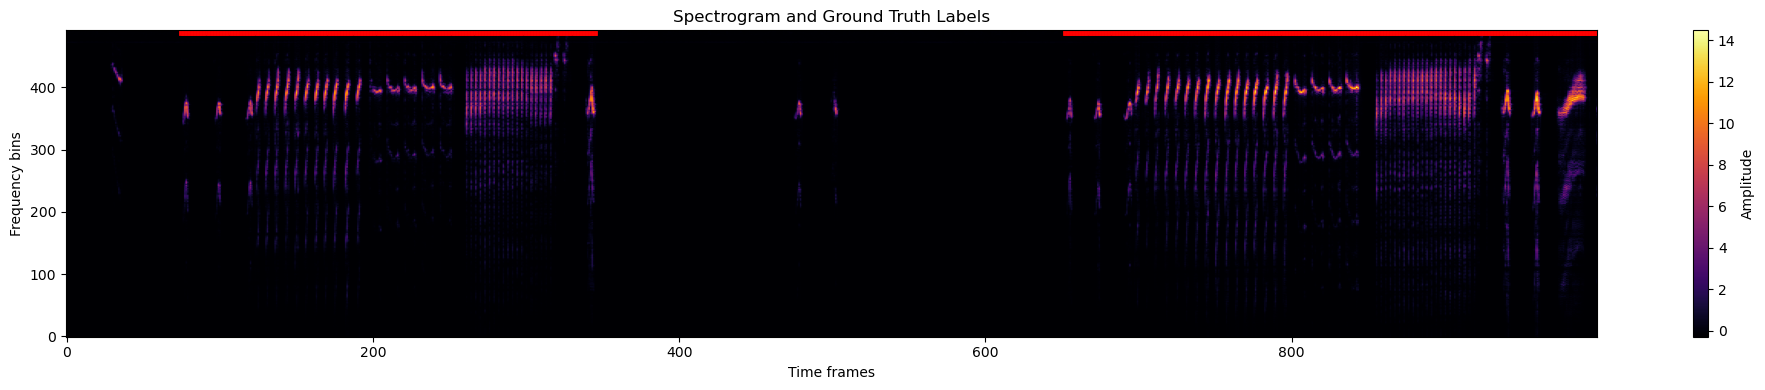

In [42]:
from data_class import SongDataSet_Image, plot_spectrogram_and_labels

train_dir = "train"
test_dir = "test"

train_dataset = SongDataSet_Image(train_dir)
test_dataset = SongDataSet_Image(test_dir)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

# Get a batch of data
spec, psuedo_labels, ground_truth_labels = next(iter(train_loader))

# Plotting
spec = spec[0].squeeze(0)  # If your data is batched, get the first item
plot_spectrogram_and_labels(spec, ground_truth_labels[0])

## Training

In [43]:
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from model import TweetyBERT

def detailed_count_parameters(model):
    """Print details of layers with the number of trainable parameters in the model."""
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        total_params += param
        # print(f"Layer: {name} | Parameters: {param:,} | Shape: {list(parameter.shape)}")
    print(f"\nTotal Trainable Parameters: {total_params:,}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

loss_list = []

model = TweetyBERT(d_transformer=64, nhead_transformer=2, embedding_dim=100, num_labels=100, tau=1, dropout=0.1, dim_feedforward=64, transformer_layers=3, reduced_embedding= 27)
detailed_count_parameters(model)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.000)


Total Trainable Parameters: 222,900


Initial Loss: 4.61e+00
Step [0/501], Training Loss: 4.6035e+00, Validation Loss: 4.5716e+00
Model saved to saved_models/model_step_0.pth
Step [50/501], Training Loss: 4.4509e+00, Validation Loss: 4.4479e+00
Step [100/501], Training Loss: 4.3991e+00, Validation Loss: 4.3973e+00
Step [150/501], Training Loss: 4.3664e+00, Validation Loss: 4.3316e+00
Step [200/501], Training Loss: 4.3141e+00, Validation Loss: 4.3124e+00
Step [250/501], Training Loss: 4.3036e+00, Validation Loss: 4.2677e+00
Step [300/501], Training Loss: 4.2524e+00, Validation Loss: 4.2947e+00
Step [350/501], Training Loss: 4.2867e+00, Validation Loss: 4.2860e+00
Step [400/501], Training Loss: 4.2476e+00, Validation Loss: 4.2007e+00
Step [450/501], Training Loss: 4.2103e+00, Validation Loss: 4.2213e+00
Step [500/501], Training Loss: 4.2213e+00, Validation Loss: 4.1839e+00
Model saved to saved_models/model_step_500.pth


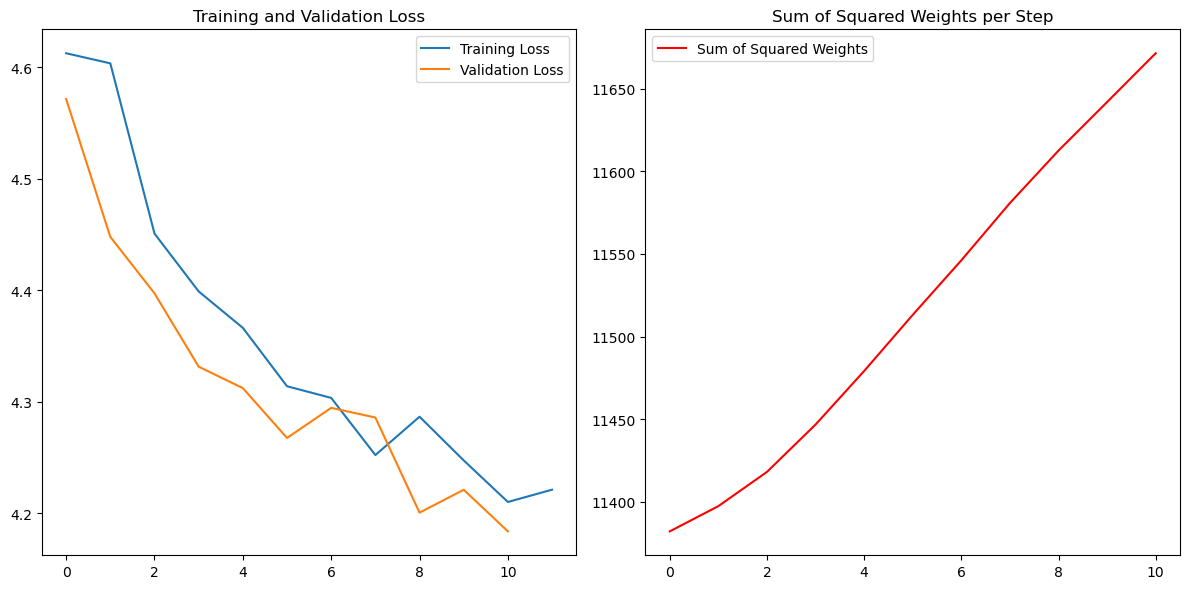

final loss 4.221319198608398


In [44]:
from trainer import ModelTrainer

# Usage:
trainer = ModelTrainer(model, train_loader, test_loader, optimizer, device, max_steps=501, eval_interval=5e1, save_interval=500)
trainer.train()
trainer.plot_results()
print(f"final loss {trainer.loss_list[-1]}")

## UMAP Analysis

In [45]:
import pickle

predictions_arr = []
psuedo_labels_arr = []
ground_truth_labels_arr =[]
spec_arr = []
layers_arr = []
batch_limit = 20
k_means_batch_limit = 10
activations = []
k_means_arr = []
cluster_labels_arr = []

def one_hot_encode(labels, num_classes=256):
    one_hot = np.zeros((labels.shape[0], num_classes))
    one_hot[np.arange(labels.shape[0]), labels] = 1
    return one_hot

for i, (data, psuedo_labels, ground_truth_label) in enumerate(train_loader):
    if i > k_means_batch_limit:
        break
    predictions, layers = model.inference_forward(data.to(device), reduced_embedding=False)
    temp = layers[-2]
    temp = temp.reshape(temp.shape[0] * temp.shape[1], temp.shape[2])
    activations.append(temp.detach().cpu().numpy())

k_means_arr = np.concatenate(activations, axis=0)
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(k_means_arr)


cluster_labels_arr = []
k_means_labels = []

for i, (data, psuedo_labels, ground_truth_label) in enumerate(train_loader):
    if i > batch_limit:
      break

    predictions, layers = model.inference_forward(data.to(device), reduced_embedding=False)
    temp = layers[-2]
    predictions = layers[-2]
    k_means_labels = temp
    # becomes batch + time, features 
    k_means_labels = k_means_labels.reshape(temp.shape[0] * temp.shape[1], temp.shape[2])

    k_means_labels = kmeans.predict(k_means_labels.detach().cpu().numpy())
    k_means_labels = one_hot_encode(k_means_labels, num_classes = temp.shape[2])

    # becomes batch+time, feature label

    k_means_labels = k_means_labels.reshape(temp.shape[0] * 10, 100, temp.shape[2])
    k_means_labels = torch.Tensor(k_means_labels)
    k_means_labels = torch.argmax(k_means_labels, dim=-1)
    k_means_labels = k_means_labels.squeeze(1)

    spec = data.squeeze(1).permute(0,2,1)
    predictions = predictions.reshape(predictions.shape[0] * 10, 100, predictions.shape[2])
    spec = spec.reshape(spec.shape[0] * 10, 100, spec.shape[2])
    psuedo_labels = psuedo_labels.reshape(psuedo_labels.shape[0] * 10, 100, psuedo_labels.shape[2])
    ground_truth_label = ground_truth_label.reshape(ground_truth_label.shape[0] * 10, 100, ground_truth_label.shape[2])
    predictions = predictions.flatten(1,2)

    spec = spec.flatten(1,2)
    psuedo_labels = torch.argmax(psuedo_labels, dim=-1)
    psuedo_labels = psuedo_labels.squeeze(1)
    ground_truth_label = torch.argmax(ground_truth_label, dim=-1)
    ground_truth_label = ground_truth_label.squeeze(1)

    spec_arr.append(spec.detach().cpu().numpy())
    predictions_arr.append(predictions.detach().cpu().numpy())
    ground_truth_labels_arr.append(ground_truth_label.cpu().numpy())
    psuedo_labels_arr.append(psuedo_labels.cpu().numpy())
    cluster_labels_arr.append(k_means_labels.cpu().numpy())


np.save("ground_truth_arr", ground_truth_labels_arr)
np.save("predictions_arr", predictions_arr)
np.save("psuedo_labels_arr", psuedo_labels_arr)
np.save("spec_arr", spec_arr)
np.save("cluster_labels_arr", cluster_labels_arr)

/home/george-vengrovski/anaconda3/envs/canary-vae/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


/tmp/ipykernel_3592535/1108906604.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  new_cmap = cm.get_cmap('jet', num_unique_clusters)


{0: (0.0, 0.0, 0.5, 1.0), 1: (0.5, 0.0, 0.0, 1.0)}
labels shape(6720, 100)
outputs shape(6720, 6400)
clusters shape(6720, 100)


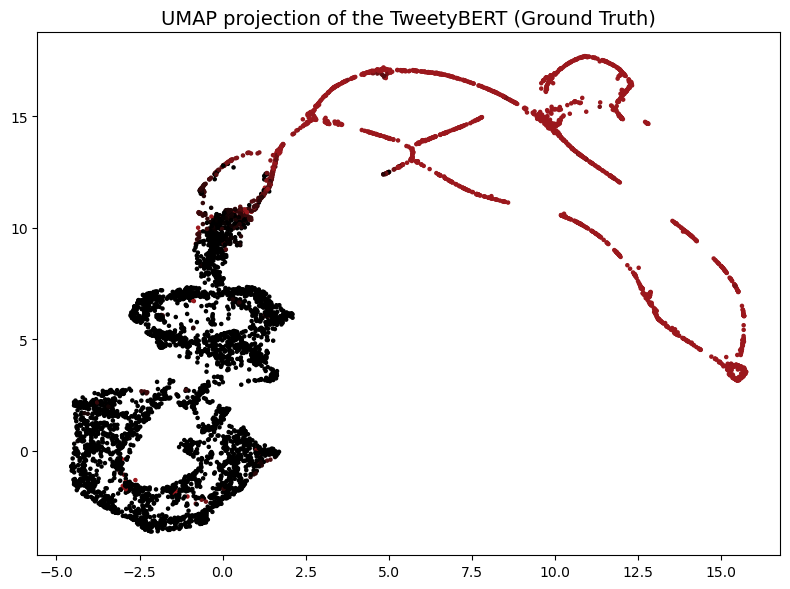

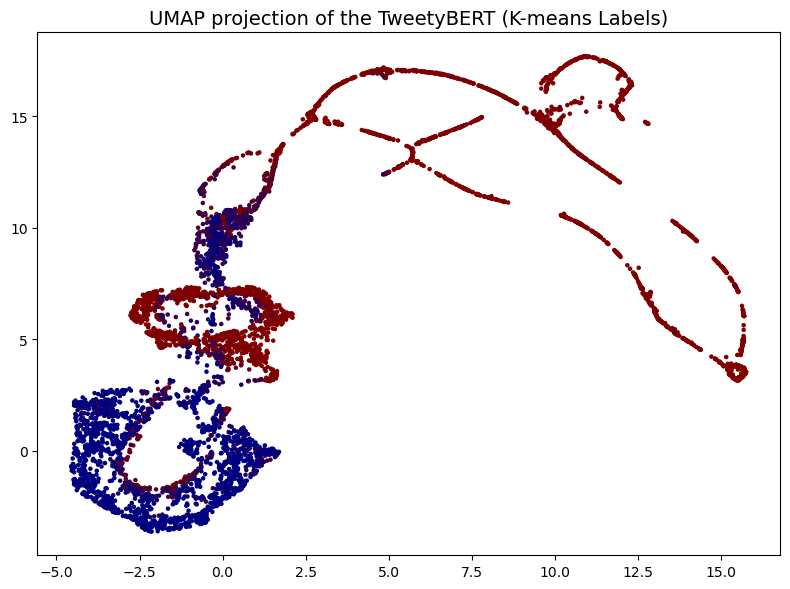

In [46]:
import umap.umap_ as umap
import matplotlib.pyplot as plt
import pickle
import numpy as np
from sklearn.cluster import KMeans
from matplotlib import cm

# Load the color map data from the pickle file
file_path = '/home/george-vengrovski/Documents/TweetyBERT/category_colors.pkl'

with open(file_path, 'rb') as file:
    color_map_data = pickle.load(file)

# Convert your color_map_data values to a format suitable for matplotlib
label_to_color = {label: tuple(color) for label, color in color_map_data.items()}

# Load prediction and ground truth labels
predictions = np.load("predictions_arr.npy", allow_pickle=True)
ground_truth_labels = np.load("ground_truth_arr.npy", allow_pickle=True)
cluster_labels = np.load("cluster_labels_arr.npy", allow_pickle=True)

# Concatenate arrays
predictions = np.concatenate([prediction for prediction in predictions], axis=0)
ground_truth_labels = np.concatenate([label for label in ground_truth_labels], axis=0)
cluster_labels = np.concatenate([label for label in cluster_labels], axis=0)

# Calculate the number of unique cluster labels
num_unique_clusters = len(np.unique(cluster_labels))

# Generate a color map
new_cmap = cm.get_cmap('jet', num_unique_clusters)

# Create a dictionary mapping cluster label to color
cluster_to_color = {label: new_cmap(i / num_unique_clusters) for i, label in enumerate(np.unique(cluster_labels))}
print(cluster_to_color)


print(f"labels shape{ground_truth_labels.shape}")
print(f"outputs shape{predictions.shape}")
print(f"clusters shape{cluster_labels.shape}")

colors_for_points = []
colors_for_clusters = []  # New list for K-means labels

# Prepare colors for ground truth labels
for label_row in ground_truth_labels:
    row_colors = [label_to_color[int(lbl)] for lbl in label_row]
    avg_color = np.mean(row_colors, axis=0)
    colors_for_points.append(avg_color)
colors_for_clusters = []  # New list for K-means labels

# Prepare colors for K-means labels
for label_row in cluster_labels:
    row_colors = [cluster_to_color[int(lbl)] for lbl in label_row]
    avg_color = np.mean(row_colors, axis=0)
    colors_for_clusters.append(avg_color)

colors_for_clusters = np.array(colors_for_clusters)  # New array for K-means labels

# Initialize UMAP reducer
reducer = umap.UMAP(random_state=42, n_neighbors=20, min_dist=0.1, n_components=2, metric='euclidean')

# UMAP projection of the TweetyBERT predictions
embedding_outputs = reducer.fit_transform(predictions)

# Plotting the UMAP projection for ground truth labels
plt.figure(figsize=(8, 6))
plt.scatter(embedding_outputs[:, 0], embedding_outputs[:, 1], s=5, c=colors_for_points)
plt.title('UMAP projection of the TweetyBERT (Ground Truth)', fontsize=14)
plt.tight_layout()
plt.show()

# Plotting the UMAP projection for K-means labels
plt.figure(figsize=(8, 6))
plt.scatter(embedding_outputs[:, 0], embedding_outputs[:, 1], s=5, c=colors_for_clusters)
plt.title('UMAP projection of the TweetyBERT (K-means Labels)', fontsize=14)
plt.tight_layout()
plt.show()

## Accuracy

In [47]:
from sklearn.metrics import f1_score
import pickle

predictions_arr = []
psuedo_labels_arr = []
ground_truth_labels_arr =[]
spec_arr = []
layers_arr = []
batch_limit = 20
k_means_batch_limit = 2
activations = []
k_means_arr = []
cluster_labels_arr = []

# for i, (data, psuedo_labels, ground_truth_label) in enumerate(train_loader):
#     if i > k_means_batch_limit:
#         break
#     predictions, layers = model.inference_forward(data.to(device), reduced_embedding=False)
#     temp = layers[-2]
#     temp = temp.reshape(temp.shape[0] * temp.shape[1], temp.shape[2])
#     activations.append(temp.detach().cpu().numpy())

# k_means_arr = np.concatenate(activations, axis=0)
# kmeans = KMeans(n_clusters=2, random_state=0)
# kmeans.fit(k_means_arr)

cluster_labels_arr = []
k_means_labels = []

for i, (data, psuedo_labels, ground_truth_label) in enumerate(train_loader):
    if i > batch_limit:
      break

    predictions, layers = model.inference_forward(data.to(device), reduced_embedding=False)
    temp = layers[-2]
    k_means_labels = temp
    # becomes batch + time, features 
    k_means_labels = k_means_labels.reshape(temp.shape[0] * temp.shape[1], temp.shape[2])

    k_means_labels = kmeans.predict(k_means_labels.detach().cpu().numpy())
    k_means_labels = one_hot_encode(k_means_labels, num_classes = temp.shape[2])

    # becomes batch+time, feature label
    k_means_labels = k_means_labels.reshape(temp.shape[0] * temp.shape[1], temp.shape[2])

    k_means_labels = torch.Tensor(k_means_labels)
    k_means_labels = torch.argmax(k_means_labels, dim=-1)

    ground_truth_label = ground_truth_label.reshape(ground_truth_label.shape[0] * ground_truth_label.shape[1], ground_truth_label.shape[2])
    ground_truth_label = torch.argmax(ground_truth_label, dim=-1)

    ground_truth_labels_arr.append(ground_truth_label.cpu().numpy())
    cluster_labels_arr.append(k_means_labels.cpu().numpy())

ground_truth_labels = np.concatenate([label for label in ground_truth_labels_arr], axis=0)
cluster_labels = np.concatenate([label for label in cluster_labels_arr], axis=0)

# cluster labels merge
cluster_labels[(cluster_labels == 0)] = 0
cluster_labels[(cluster_labels == 1)] = 1

from sklearn.metrics import f1_score

# Assuming ground_truth_labels and cluster_labels are NumPy arrays
f1 = f1_score(ground_truth_labels, cluster_labels, average='weighted')

print(f'F1 Score: {f1}')

F1 Score: 0.7433013583387346
